<a href="https://colab.research.google.com/github/khouakhi/WEDC_Msc/blob/master/intro_to_pandas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### 

# Intro to pandas

**Learning Objectives:**
  * Gain an introduction to the `DataFrame` and `Series` data structures of the *pandas* library
  * Access and manipulate data within a `DataFrame` and `Series`
  * Import CSV data into a *pandas* `DataFrame`
  * Reindex a `DataFrame` to shuffle data

[*pandas*](http://pandas.pydata.org/) is a column-oriented data analysis API. It's a great tool for handling and analyzing input data, and many ML frameworks support *pandas* data structures as inputs.
Although a comprehensive introduction to the *pandas* API would span many pages, the core concepts are fairly straightforward, and we'll present them below. For a more complete reference, the [*pandas* docs site](http://pandas.pydata.org/pandas-docs/stable/index.html) contains extensive documentation and many tutorials.

## using water levl data

The following line imports the *pandas* API and prints the API version:

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

pd.__version__

'0.25.3'

In [0]:
from google.colab import drive
drive.mount('/content/drive')

The primary data structures in *pandas* are implemented as two classes:

  * **`DataFrame`**, which you can imagine as a relational data table, with rows and named columns.
  * **`Series`**, which is a single column. A `DataFrame` contains one or more `Series` and a name for each `Series`.

The data frame is a commonly used abstraction for data manipulation. Similar implementations exist in [Spark](https://spark.apache.org/) and [R](https://www.r-project.org/about.html).

One way to create a `Series` is to construct a `Series` object. For example:

In [88]:
rainfall_source = '/content/drive/My Drive/data/rainfall'

file_name = 'Burton on the Wolds 3629 15 Minute Rainfall.csv'
usecols = range(8)

#dateparser = lambda x: pd.datetime.strptime(x,'%d/%m/%Y %H:%M:%S')

data = pd.read_csv(os.path.join(rainfall_source,file_name),
                   skiprows = 20,
                   #parse_dates=['Time stamp']
                   usecols = usecols)

print(data.dtypes)
print(data.describe())
print(data.columns)

# rename variables 
new_columns = ['time_stamp','rainfall', 'state','interp',
               'valid','invalid', 'missing', 'tags']
data.columns = new_columns
# remove the wrong rows
data.isna().any()
# remove the wrong rows
data= data[data.time_stamp != 'Raingauge Frozen']
# parse datetime
data['time_stamp'] = pd.to_datetime(data['time_stamp'], format='%d/%m/%Y %H:%M:%S')
# convert stage to numeric
data['rainfall'] = data['rainfall'].apply(pd.to_numeric, errors='coerce')
# set index
data = data.set_index('time_stamp')

print(data.describe())
# check the data state
data.state.unique()

hourly_precip = data[['rainfall']].resample('h').sum()

digits = [int(i) for i in file_name.split() if i.isdigit()]

new_name_path = os.path.join(rainfall_source,f'{digits[0]}.csv')

if os.path.isfile(new_name_path):
  hourly_precip.to_csv(new_name_path), mode='a', header=False)
else:
  hourly_precip.to_csv(os.path.join(rainfall_source,f'{digits[0]}.csv'))

True

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


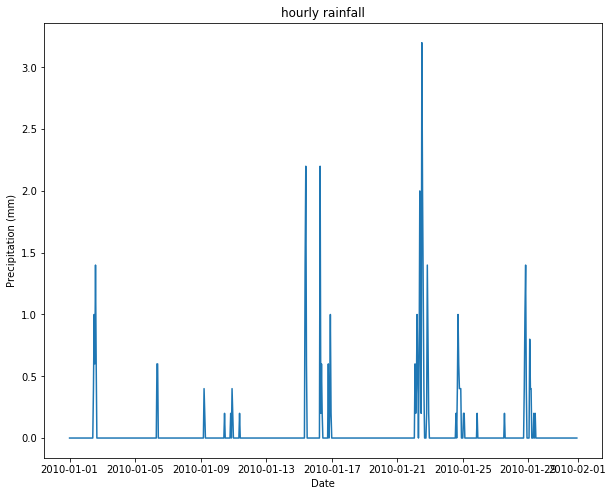

In [117]:
# Plot the data 
fig, ax = plt.subplots(figsize = (10,8))
ax.plot(hourly_precip['01-2010'])
ax.set(xlabel='Date', ylabel='Precipitation (mm)',
       title="hourly rainfall")
plt.show()

`DataFrame` objects can be created by passing a `dict` mapping `string` column names to their respective `Series`. If the `Series` don't match in length, missing values are filled with special [NA/NaN](http://pandas.pydata.org/pandas-docs/stable/missing_data.html) values. Example:

In [0]:
rainfall_source = '/content/drive/My Drive/data/rainfall'
# define a function that reads and prepare the rainfall data 
def data_prep(dir_path,file_name):
  data = pd.read_csv(os.path.join(dir_path,file_name),
                    skiprows = 20,
                    #parse_dates=['Time stamp']
                    usecols =  range(8))
  print('the imported file is: %s' % file_name)
  # rename variables 
  new_columns = ['time_stamp','rainfall', 'state','interp',
                'valid','invalid', 'missing', 'tags']
  data.columns = new_columns
  # convert stage to numeric
  data['rainfall'] = data['rainfall'].apply(pd.to_numeric, errors='coerce')
  # drop Nas from rainfall column
  data.dropna(subset=['rainfall'], how='all', inplace=True) 
  # parse datetime
  data['time_stamp'] = pd.to_datetime(data['time_stamp'], format='%d/%m/%Y %H:%M:%S')
  # set date time as index
  data = data.set_index('time_stamp')
  # aggregate data to hourly 
  print('now resample rainfall to hourly time series....')
  hourly_precip = data[['rainfall']].resample('h').sum()
  print('done!')
  return(hourly_precip)
# create new folder for the processed precip data
precip_out_path = '/content/drive/My Drive/data/precip_proc1/'
try:
    os.mkdir(precip_out_path)
except OSError:
    print ("file exists already %s:" % precip_out_path)
else:
    print ("Successfully created the directory %s " % precip_out_path)

# list precip files
file_names = os.listdir(rainfall_source)
# iterate through all rainfall files  
for f in file_names:
  hourly_precip = data_prep(rainfall_source,f)
  # extract the station ID from the file name 
  digi_name = [int(i) for i in f.split() if i.isdigit()]
  # new name path
  new_name_path = os.path.join(precip_out_path,f'P{digi_name[0]}.csv')
  # if the file exists append, if not create new
  if os.path.isfile(new_name_path):
    hourly_precip.to_csv(new_name_path, mode='a', header=False)
  else:
    hourly_precip.to_csv(os.path.join(precip_out_path,f'P{digi_name[0]}.csv'))

The example above used `DataFrame.describe` to show interesting statistics about a `DataFrame`. Another useful function is `DataFrame.head`, which displays the first few records of a `DataFrame`:

[NumPy](http://www.numpy.org/) is a popular toolkit for scientific computing. *pandas* `Series` can be used as arguments to most NumPy functions: